Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train")
data_dir_test = pathlib.Path('E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.a
directory="E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train"
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.10,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 6739 files belonging to 9 classes.
Using 6066 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.10,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6739 files belonging to 9 classes.
Using 673 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
class_names = val_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
print(len(val_ds))
print(len(train_ds))

22
190


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

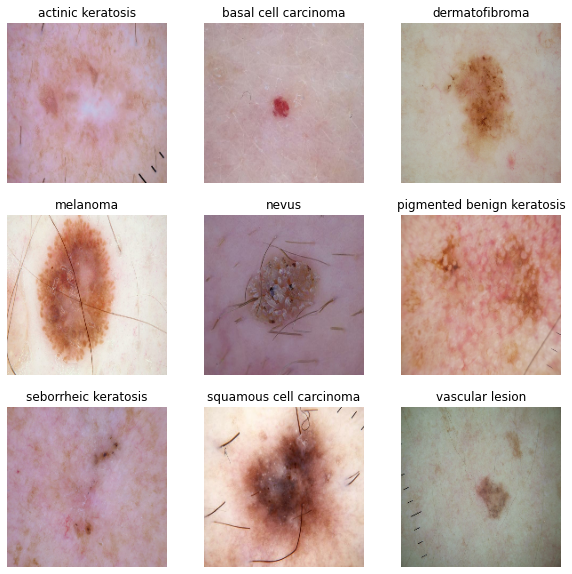

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  lbl=class_names
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(lbl[i])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



0.0 0.92026037


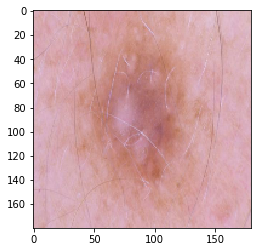

In [13]:
from matplotlib import pyplot as plt
plt.imshow(image_batch.numpy()[31], interpolation='nearest')
plt.show()

In [14]:
# img = PIL.Image.fromarray(image_batch.numpy()[0], 'RGB')
# img.save('my.png')
# img.show()

In [78]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [79]:
input_img = (180, 180, 3)

model = Sequential()
model.add(Rescaling(1./255,input_shape=input_img))
model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names),activation='softmax'))

### Compile the model
####Choose an appropirate optimiser and loss function for model training 

In [81]:
len(class_names)

9

In [82]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [83]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 89, 89, 64)        18496     
                                                      

### Train the model

In [23]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
63/63 [==============================] - 71s 982ms/step - loss: 2.3283 - accuracy: 0.2455 - val_loss: 2.0240 - val_accuracy: 0.2377
Epoch 2/30
63/63 [==============================] - 59s 931ms/step - loss: 1.8625 - accuracy: 0.2996 - val_loss: 1.7171 - val_accuracy: 0.3901
Epoch 3/30
63/63 [==============================] - 59s 932ms/step - loss: 1.7841 - accuracy: 0.3512 - val_loss: 1.7521 - val_accuracy: 0.4081
Epoch 4/30
63/63 [==============================] - 59s 932ms/step - loss: 1.6452 - accuracy: 0.3993 - val_loss: 1.6564 - val_accuracy: 0.3946
Epoch 5/30
63/63 [==============================] - 59s 933ms/step - loss: 1.5069 - accuracy: 0.4658 - val_loss: 1.6278 - val_accuracy: 0.4305
Epoch 6/30
63/63 [==============================] - 59s 931ms/step - loss: 1.4644 - accuracy: 0.4861 - val_loss: 1.5202 - val_accuracy: 0.4753
Epoch 7/30
63/63 [==============================] - 59s 933ms/step - loss: 1.3833 - accuracy: 0.5198 - val_loss: 1.5642 - val_accuracy: 0.4978

### Visualizing training results

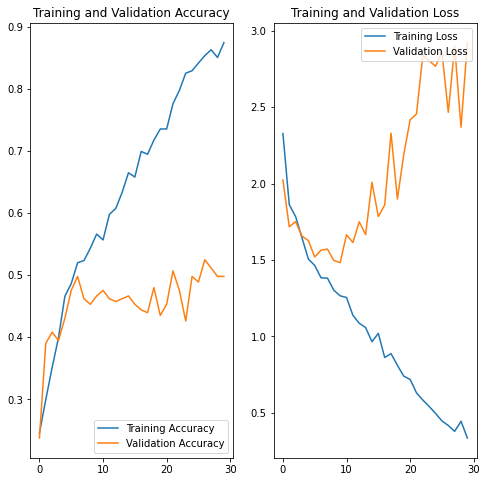

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- __The Model Overfits as Training Accuracy is ~87% but Validation Accuracy is ~48%, hence we should need to do some regularization of use better optimizer to handle this situation__


In [15]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')


train_generator = train_datagen.flow_from_directory(
        directory,  # this is the input directory
        target_size=(img_height,img_width),  # all images will be resized to 64x64
        batch_size=batch_size,
        class_mode='binary')  



Found 2239 images belonging to 9 classes.


### Todo:
### Create the model, compile and train the model


In [16]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
input_img = (180, 180, 3)

model = Sequential()
model.add(Rescaling(1./255,input_shape=input_img))
model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(Dropout(0.20))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names),activation='softmax'))

### Compile the model
####Choose an appropirate optimiser and loss function for model training 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


       

### Compiling the model

In [17]:
## Your code goes here
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 dropout (Dropout)           (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        18496     
                                                        

### Training the model

In [18]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2240 // batch_size,    #The 2 slashes division return rounded integer
        epochs=30,
        validation_data=val_ds,
        validation_steps=250 // batch_size)

C:\Users\PC\AppData\Local\Temp/ipykernel_11004/522914357.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
70/70 [==============================] - 89s 1s/step - loss: 3.8888 - accuracy: 0.1929 - val_loss: 2.1185 - val_accuracy: 0.1704
Epoch 2/30
70/70 [==============================] - 76s 1s/step - loss: 2.0522 - accuracy: 0.2019 - val_loss: 2.1596 - val_accuracy: 0.2108
Epoch 3/30
70/70 [==============================] - 76s 1s/step - loss: 2.0379 - accuracy: 0.2046 - val_loss: 2.1143 - val_accuracy: 0.2063
Epoch 4/30
70/70 [==============================] - 76s 1s/step - loss: 1.9126 - accuracy: 0.2899 - val_loss: 1.8767 - val_accuracy: 0.2511
Epoch 5/30
70/70 [==============================] - 75s 1s/step - loss: 1.7489 - accuracy: 0.3569 - val_loss: 1.7629 - val_accuracy: 0.3318
Epoch 6/30
70/70 [==============================] - 76s 1s/step - loss: 1.6421 - accuracy: 0.4064 - val_loss: 1.6663 - val_accuracy: 0.4215
Epoch 7/30
70/70 [==============================] - 76s 1s/step - loss: 1.5965 - accuracy: 0.4167 - val_loss: 1.7365 - val_accuracy: 0.3722
Epoch 8/30
70/70 [==

### Visualizing the results

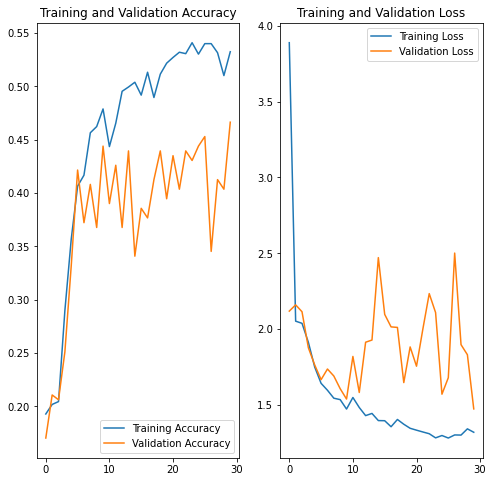

In [20]:
epochs=30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [22]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20BBC04DC40>: 100%|█| 500/500 [00:02<00:00, 190.73 Samples


Initialised with 376 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20BDF66DA30>: 100%|█| 500/500 [00:02<00:00, 197.74 Samples


Initialised with 95 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20BDB031E80>: 100%|█| 500/500 [00:02<00:00, 201.17 Samples


Initialised with 438 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x20BD97D4C70>: 100%|█| 500/500 [00:10<00:


Initialised with 357 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x20BDB4F0280>: 100%|█| 500/500 [00:11<0


Initialised with 462 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20C7F079E50>: 100%|█| 500/500 [00:02<00:


Initialised with 77 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x20BBE9051C0>: 100%|█| 500/500 [00:05<00:00, 86.96 Samples


Initialised with 181 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20C7F01A850>: 100%|█| 500/500 [00:02<00:


Initialised with 139 image(s) found.
Output directory set to E:\UpGrad\Code\case_study\CNN\CNN_assignment\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20BC66F5400>: 100%|█| 500/500 [00:02<00:00, 201.05 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train,'*','output', '*.jpg'))]
path_list

['E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8f42dc5f-21b5-40e2-a40e-62e2286d1582.jpg',
 'E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_af5bcee8-fe15-4083-b28c-1b7928df4e2d.jpg',
 'E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b082c286-ee7a-4b59-9d4b-f89ad0581394.jpg',
 'E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ba4428d3-1754-4925-b9ac-9fec8878d255.jpg',
 'E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [49]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [52]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df =df2.copy()

In [53]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [14]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [15]:
data_dir_train=directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [26]:
input_img = (180, 180, 3)

model = Sequential()
model.add(Rescaling(1./255,input_shape=input_img))
model.add(Conv2D(16, (3, 3), padding='same',activation='relu'))
model.add(Dropout(0.15))
model.add(Conv2D(16, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(Dropout(0.20))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names),activation='softmax'))



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [27]:

### Compile the model
####Choose an appropirate optimiser and loss function for model training 

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 dropout_9 (Dropout)         (None, 180, 180, 16)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 89, 89, 32)        4640      
                                                      

#### **Todo:**  Train your model

In [29]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 101s 589ms/step - loss: 2.0277 - accuracy: 0.2122 - val_loss: 2.0124 - val_accuracy: 0.2027
Epoch 2/30
169/169 [==============================] - 98s 579ms/step - loss: 1.6399 - accuracy: 0.3704 - val_loss: 1.6247 - val_accuracy: 0.3719
Epoch 3/30
169/169 [==============================] - 97s 574ms/step - loss: 1.4654 - accuracy: 0.4368 - val_loss: 1.6436 - val_accuracy: 0.3653
Epoch 4/30
169/169 [==============================] - 97s 574ms/step - loss: 1.3272 - accuracy: 0.4859 - val_loss: 1.4838 - val_accuracy: 0.4246
Epoch 5/30
169/169 [==============================] - 97s 574ms/step - loss: 1.2910 - accuracy: 0.5020 - val_loss: 1.3983 - val_accuracy: 0.4380
Epoch 6/30
169/169 [==============================] - 97s 574ms/step - loss: 1.1961 - accuracy: 0.5478 - val_loss: 1.5432 - val_accuracy: 0.4350
Epoch 7/30
169/169 [==============================] - 97s 574ms/step - loss: 1.1145 - accuracy: 0.5809 - val_loss: 1.3020 - val_a

#### **Todo:**  Visualize the model results

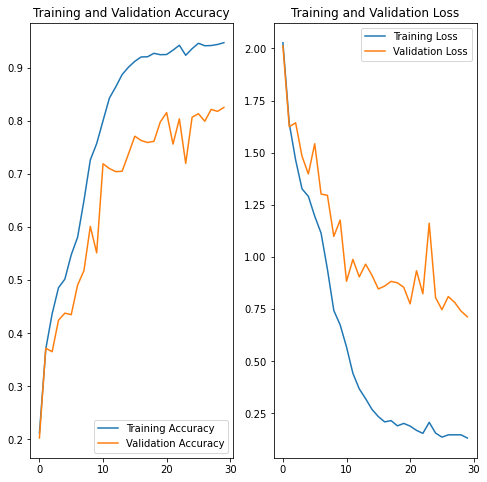

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1st iteration 
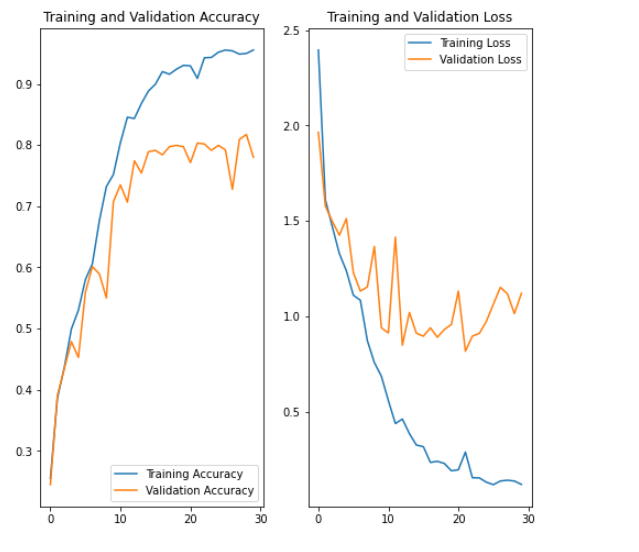

2nd Iteration 
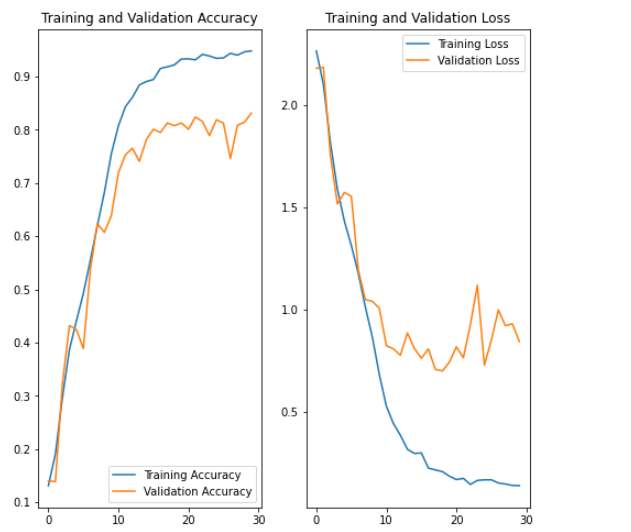

3rd iteration 

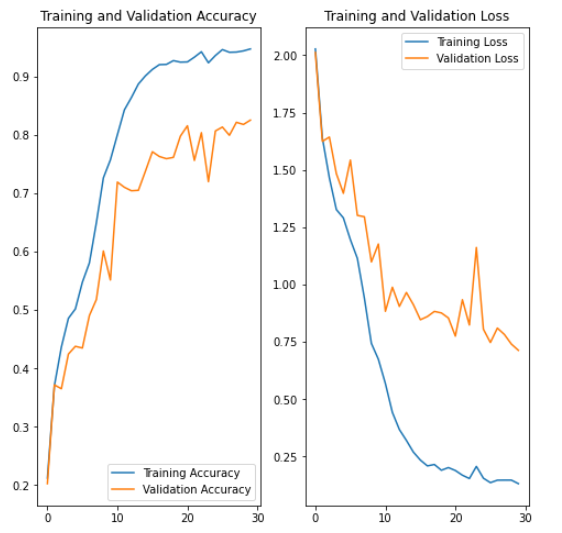


- After using the augmnettaion technique whihc helped to reduce the overfitting and also help to predict correct prediction  

In [32]:
data_dir_test="E:\\UpGrad\\Code\\case_study\\CNN\\CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [36]:
for img,labels in test_ds:
    print(img[0])
    print(labels[0])
    y_hat=model.predict(img[0])

C:\Users\PC\AppData\Local\Temp/ipykernel_16836/1874070665.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_hat=model.predict_generator(test_ds)


In [38]:
y_argmax=np.argmax(y_hat)

In [49]:
for img,labels in test_ds:
    print(img[0])
    print(labels[0])

tf.Tensor(
[[[112.38617  111.126785 109.81531 ]
  [117.44408  115.84333  115.64555 ]
  [124.485794 123.485794 119.73024 ]
  ...
  [126.12222  116.63712  109.97474 ]
  [121.167114 115.02249  108.700806]
  [123.64833  112.66326  106.83303 ]]

 [[117.912224 114.55592  116.044815]
  [120.39556  119.79667  117.06333 ]
  [128.25185  128.47777  123.72221 ]
  ...
  [120.757515 111.326    108.00193 ]
  [118.668106 109.936745 104.06927 ]
  [120.621445 111.0103   102.82111 ]]

 [[124.09876  121.803085 118.45679 ]
  [130.10555  129.77777  126.409256]
  [150.46606  143.46605  125.97532 ]
  ...
  [124.76241  114.23773  112.23773 ]
  [120.998055 110.38515  108.38515 ]
  [124.02536  115.02536  106.80313 ]]

 ...

 [[ 92.92718   85.67897   86.7778  ]
  [ 93.262924  82.69444   86.91666 ]
  [ 95.64501   83.79628   88.54016 ]
  ...
  [137.79332  138.79332  122.79333 ]
  [136.16068  136.97766  119.60906 ]
  [132.51491  130.70993  113.41791 ]]

 [[ 91.44399   89.34426   86.59883 ]
  [ 90.46631   82.42992   

In [50]:
np.argmax(y_hat[1])

4